<a href="https://colab.research.google.com/github/KuoJeffrey/digitRecognizer/blob/master/lenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# TPU initialization
import tensorflow as tf
try:
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
except:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')


tf.config.experimental_connect_to_cluster(resolver)

# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

CORE = strategy.scope()

BaseException: ignored

In [4]:
# GPU initialization
import tensorflow as tf
device_name = tf.test.gpu_device_name()

if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')

print('Found GPU at: {}'.format(device_name))

CORE = tf.device(device_name)

Found GPU at: /device:GPU:0


In [5]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from matplotlib import pyplot as plt

In [7]:
train_data_url = "digit-recognizer/train.csv"
train_data = pd.read_csv(train_data_url)

test_data_url = "digit-recognizer/test.csv"
test_data = pd.read_csv(test_data_url)


In [6]:
BATCH_SIZE = 128
EPOCH = 30
SEED = 2187256

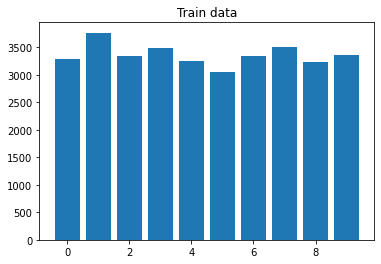

In [8]:
train_label = pd.get_dummies(train_data.label)
train_input = train_data.drop('label', axis=1) / 255

x_train, x_val, y_train, y_val = train_test_split(
    train_input, train_label, 
    train_size = 0.8, 
    test_size = 0.2, 
    random_state = SEED
)

x_train = x_train.to_numpy().reshape(33600, 28, 28, 1)
x_val = x_val.to_numpy().reshape(8400, 28, 28, 1)
x_test = test_data.to_numpy().reshape(28000, 28, 28, 1) / 255

plt.figure("Train data")
plt.title("Train data")
plt.bar(np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), np.sum(y_train))
plt.savefig("img/train_data_hist.png")

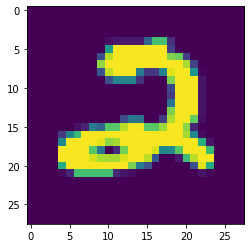

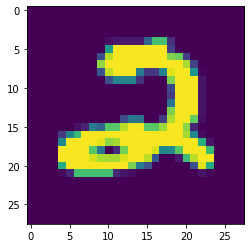

In [9]:
# Data augmentation
test = x_test[0, :, :, 0]
test2 = (test - test.mean()) / test.std()

plt.imshow(test)
plt.show()
plt.imshow(test2)
plt.show()

In [10]:
# Model 0
MODEL = "LeNet-5"

def model0():
  
  model = keras.Sequential([
    
    # Convolution layer
    layers.Conv2D(filters=6, kernel_size=(5, 5), activation='relu', padding="same", input_shape=(28, 28, 1)),

    # Pooling layer
    layers.AveragePooling2D(),

    # Convolution layer
    layers.Conv2D(filters=16, kernel_size=(5, 5), activation='relu'), 

    # Pooling layer
    layers.AveragePooling2D(),

    # Fully connected layer
    layers.Flatten(), 
    layers.Dense(units=120, activation='relu'),
    layers.Dense(units=84, activation="relu"), 

    # Output layer
    layers.Dense(units=10, activation='softmax')
      
  ])

  return model

In [ ]:
# Model 1
MODEL = "LeNet"

def model1():
  model = keras.Sequential([
      
      # Convolution layer
      layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', padding="same", input_shape=(28, 28, 1)),

      # Pooling layer
      layers.AveragePooling2D(),

      # Convolution layer
      layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),

      # Pooling layer
      layers.AveragePooling2D(),

      # Fully connected layer
      layers.Flatten(),
      layers.Dense(units=120, activation='relu'),

      # Fully connected layer
      layers.Dense(units=84, activation="relu"), 

      # Output layer
      layers.Dense(units=10, activation='softmax')

  ])

  return model

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 28, 28, 6)         60        
                                                                 
 average_pooling2d_2 (Averag  (None, 14, 14, 6)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_15 (Conv2D)          (None, 12, 12, 16)        880       
                                                                 
 average_pooling2d_3 (Averag  (None, 6, 6, 16)         0         
 ePooling2D)                                                     
                                                                 
 flatten_3 (Flatten)         (None, 576)               0         
                                                                 
 dense_9 (Dense)             (None, 120)              

In [ ]:
# Model 2
MODEL = "deepLeNet"

def model2():

  model = keras.Sequential([
      
      # Convolution layer
      layers.Conv2D(filters=32, kernel_size=5, activation='relu', padding="same", input_shape=(28, 28, 1), kernel_regularizer=regularizers.l2(0.0005)),
      layers.Conv2D(filters=32, kernel_size=5, use_bias=False),

      # Batch normalization, activation, maxpooling, dropout
      layers.BatchNormalization(),
      layers.Activation("relu"),
      layers.MaxPooling2D(pool_size=2, strides=2),
      layers.Dropout(0.25),


      # Convolution layer
      layers.Conv2D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=regularizers.l2(0.0005)),
      layers.Conv2D(filters=64, kernel_size=3, use_bias=False),

      # Batch normalization, activation, maxpooling, dropout
      layers.BatchNormalization(),
      layers.Activation("relu"),
      layers.MaxPooling2D(pool_size=2, strides=2),
      layers.Dropout(0.25),


      # Fully connected layer
      layers.Flatten(),
      layers.Dense(units=256, use_bias=False),

      # Batch normalization, activation
      layers.BatchNormalization(),
      layers.Activation("relu"),


      # Fully connected layer
      layers.Dense(units=128, use_bias=False), 

      # Batch normalization, activation
      layers.BatchNormalization(),
      layers.Activation("relu"),


      # Fully connected layer
      layers.Dense(units = 84, use_bias=False),

      # Batch normalization, activation, dropout
      layers.BatchNormalization(),
      layers.Activation("relu"),
      layers.Dropout(0.25),


      # Output layer
      layers.Dense(units=10, activation='softmax')
  ])

  return model

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_76 (Conv2D)          (None, 28, 28, 32)        832       
                                                                 
 conv2d_77 (Conv2D)          (None, 24, 24, 32)        25600     
                                                                 
 batch_normalization_49 (Bat  (None, 24, 24, 32)       128       
 chNormalization)                                                
                                                                 
 activation_46 (Activation)  (None, 24, 24, 32)        0         
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 12, 12, 32)       0         
 g2D)                                                            
                                                                 
 dropout_60 (Dropout)        (None, 12, 12, 32)      

In [39]:
# Model 3
MODEL = "myModel"

def model3():
  
    model = keras.Sequential([
        
        # Convolution layer
        layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", kernel_regularizer=regularizers.l2(0.0005)), 
        layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", kernel_regularizer=regularizers.l2(0.0005)),
        layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", use_bias=False),

        # Batch nomalization, activation, maxpooling, dropout
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
        layers.Dropout(0.25),

        # Convolution layer
        layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", kernel_regularizer=regularizers.l2(0.0005)), 
        layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", kernel_regularizer=regularizers.l2(0.0005)),
        layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", use_bias=False),

        # Batch nomalization, activation, maxpooling, dropout
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
        layers.Dropout(0.25),

        # Fully connected layer
        layers.Flatten(),
        layers.Dense(units=4096, activation="relu", use_bias=False), 
        layers.Dense(units=4096, use_bias=False), 

        # Batch normalization, activation, dropout
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.Dropout(0.25),

        # Output layer
        layers.Dense(units=10, activation="softmax")

    ])
    
    return model

In [11]:
with CORE:
  if MODEL == "LeNet-5":
    model = model0()
  elif MODEL == "LeNet":
    model = model1()
  elif MODEL == "deepLeNet":
    model = model2()
  elif MODEL == "myModel":
    model = model3()
  else:
    raise "Model doesn't exist"
  model.compile(
      optimizer = "adam", 
      loss = "categorical_crossentropy", 
      metrics = ["categorical_accuracy"]
  )

early_stopping = keras.callbacks.EarlyStopping(
    patience = 5, 
    min_delta = 0.001,
    restore_best_weights = True,
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.2,
    patience = 2
)

history = model.fit(
    x_train, y_train,
    validation_data = (x_val, y_val),
    batch_size = BATCH_SIZE,
    epochs = EPOCH,
    callbacks = [early_stopping, reduce_lr],
)

Epoch 1/30
263/263 [==============================] - 32s 9ms/step - loss: 0.5139 - categorical_accuracy: 0.8453 - val_loss: 0.1911 - val_categorical_accuracy: 0.9408 - lr: 0.0010
Epoch 2/30
263/263 [==============================] - 2s 8ms/step - loss: 0.1367 - categorical_accuracy: 0.9596 - val_loss: 0.1017 - val_categorical_accuracy: 0.9673 - lr: 0.0010
Epoch 3/30
263/263 [==============================] - 2s 8ms/step - loss: 0.0962 - categorical_accuracy: 0.9714 - val_loss: 0.0858 - val_categorical_accuracy: 0.9737 - lr: 0.0010
Epoch 4/30
263/263 [==============================] - 2s 8ms/step - loss: 0.0763 - categorical_accuracy: 0.9766 - val_loss: 0.0688 - val_categorical_accuracy: 0.9793 - lr: 0.0010
Epoch 5/30
263/263 [==============================] - 2s 8ms/step - loss: 0.0627 - categorical_accuracy: 0.9812 - val_loss: 0.0686 - val_categorical_accuracy: 0.9786 - lr: 0.0010
Epoch 6/30
263/263 [==============================] - 2s 8ms/step - loss: 0.0547 - categorical_accuracy:

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 5, 5, 16)         0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense (Dense)               (None, 120)               4

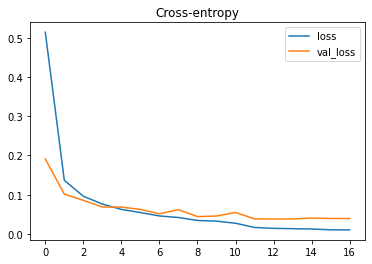

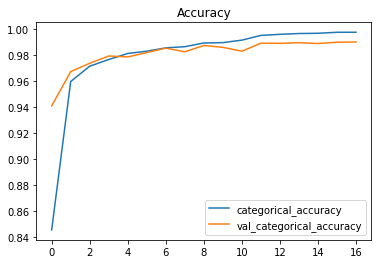

In [12]:
model.summary()

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
plt.savefig("img/loss_{}.png".format(MODEL))

history_df.loc[:, ['categorical_accuracy', 'val_categorical_accuracy']].plot(title="Accuracy")
plt.savefig("img/acc_{}.png".format(MODEL))

In [13]:
y_test = model.predict(x_test)
y_test = np.argmax(y_test, axis=1)

submission = pd.DataFrame(columns=['ImageId', 'Label'])
submission['ImageId'] = range(1, 1+len(y_test))
submission['Label'] = y_test

submission.to_csv('digit-recognizer/submission_{}.csv'.format(MODEL), index=False)

In [14]:
my_submission = pd.read_csv('digit-recognizer/submission_{}.csv'.format(MODEL))
my_submission

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


## Experiment

In [ ]:
a = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0], 
    [1, 1, 1, 1, 1, 1, 1, 1], 
    [2, 2, 2, 2, 2, 2, 2, 2]
])

print(a.reshape(3, 2, 4))

[[[0 0 0 0]
  [0 0 0 0]]

 [[1 1 1 1]
  [1 1 1 1]]

 [[2 2 2 2]
  [2 2 2 2]]]
